Problem Description

In this project, we were tasked with the creation of a machine learning model capable of identifying metastatic cancer in small image patches taken from larger digital pathology scans. Our dataset, a slightly altered version of the PatchCamelyon (PCam) benchmark dataset, comprised of histopathological scans with two labels: '0' indicating the absence of metastatic tissue and '1' for its presence. It's worth noting that unlike the original PCam dataset, which contains duplicate images due to its probabilistic sampling, our version from Kaggle had all duplicates removed.

Our goal was not just to design a model that could accurately distinguish between metastatic and non-metastatic tissue, but also to ensure that this model was efficient and fast to meet real-world demands. This task posed a challenging problem in the field of binary image classification and required the use of deep learning techniques to effectively solve it. Ultimately, our task was to strike an optimal balance between the predictive accuracy of the model and its computational efficiency.

Github Link:
https://github.com/Vamboozer/AI/tree/0ba6dc25d8425192ba94fd95b55327a49d0cf27d/DeepLearning/histopathologic-cancer-detection

In [14]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
print(sys.version)

#!pip install virtualenv
#!virtualenv tf_env
#!tf_env\Scripts\activate
#!pip install tensorflow keras
#!pip install shutil

#!jupyter notebook
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]


Exploratory Data Analysis (EDA)

In [6]:
train_labels = pd.read_csv('D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


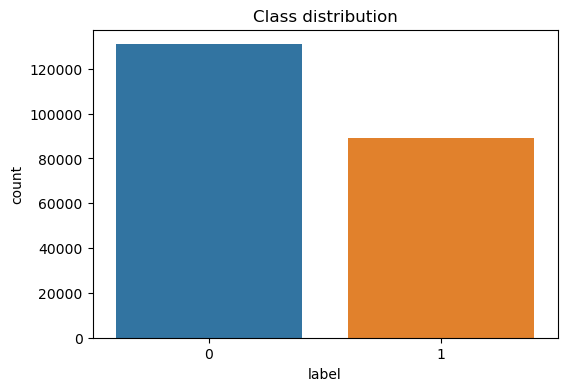

In [15]:
# Check class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Class distribution')
plt.show()

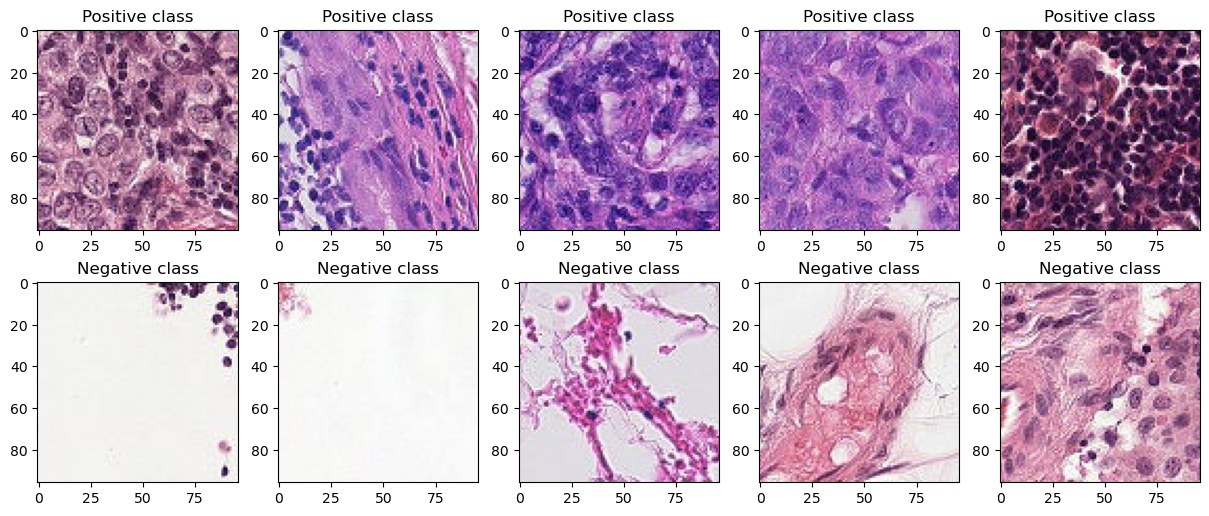

In [19]:
# Display some images from both classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Select random image from each class
    random_pos_img = train_data[train_data['label'] == 1].sample(1)['id'].values[0]
    random_neg_img = train_data[train_data['label'] == 0].sample(1)['id'].values[0]
    
    pos_img = Image.open(f'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/{random_pos_img}')
    neg_img = Image.open(f'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/{random_neg_img}')
    
    # Plot positive class image
    axes[0, i].imshow(pos_img)
    axes[0, i].set_title('Positive class')
    
    # Plot negative class image
    axes[1, i].imshow(neg_img)
    axes[1, i].set_title('Negative class')

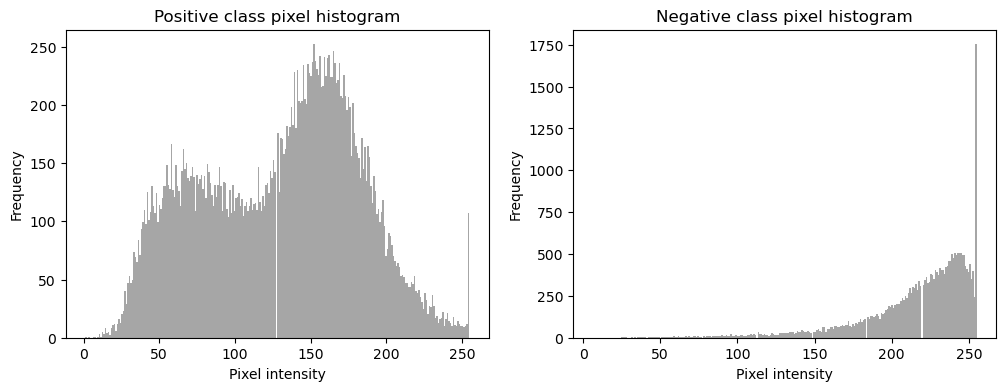

In [23]:
# Select a random positive image and a random negative image
random_pos_img = train_data[train_data['label'] == 1].sample(1)['id'].values[0]
random_neg_img = train_data[train_data['label'] == 0].sample(1)['id'].values[0]

# Load images
pos_img = Image.open(f'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/{random_pos_img}')
neg_img = Image.open(f'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/{random_neg_img}')

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot positive class histogram
axs[0].hist(np.array(pos_img).ravel(), bins=256, color='gray', alpha=0.7)
axs[0].set_title('Positive class pixel histogram')
axs[0].set_xlabel('Pixel intensity')
axs[0].set_ylabel('Frequency')

# Plot negative class histogram
axs[1].hist(np.array(neg_img).ravel(), bins=256, color='gray', alpha=0.7)
axs[1].set_title('Negative class pixel histogram')
axs[1].set_xlabel('Pixel intensity')
axs[1].set_ylabel('Frequency')

plt.show()

Model Architecture

The Convolutional Neural Network (CNN) architecture was chosen for this task primarily because it is well-suited for image classification problems. CNNs are adept at handling high-dimensional inputs, such as images, and can effectively learn hierarchical patterns from raw pixel data. This means they can recognize increasingly complex features at each layer, which is ideal for tasks like ours where we aim to identify cancerous cells amidst healthy ones in an image.

The structure of the CNN model was determined based on several considerations. First, the use of convolutional layers is fundamental in a CNN architecture. These layers convolve the input with a set of learnable filters, each aiming to detect a different feature in the input. The model had three convolutional layers, which allowed the model to learn a hierarchical structure of features - simple patterns at the first layer (like edges and textures), and more complex patterns (like shapes and specific structures of the cells) at the deeper layers.

MaxPooling layers were incorporated after each Conv2D layer to progressively reduce the spatial size of the representation. The main advantages of this strategy are twofold: First, it lowers the computational burden by decreasing the dimensionality of the inputs for subsequent layers. Secondly, it provides a form of translation invariance, which means the model can recognize a pattern regardless of its position in the image. This characteristic is particularly useful in tasks such as ours where the location of cancerous cells within the patch is not fixed.

The model used two dense layers at the end - the first one with 64 units and ReLU activation, and the second one with 1 unit and sigmoid activation. Dense layers, also known as fully connected layers, connect each neuron in the previous layer to every neuron in the next layer. The first dense layer further processes the features learned by the convolutional and pooling layers, while the final dense layer, paired with a sigmoid activation function, outputs the probability that the input image contains metastatic cancer.

The number of layers and their configurations were decided empirically. In general, a deeper network can model more complex patterns, but it also runs the risk of overfitting, especially when the amount of data is limited. Given the time and computational constraints, and the need to mitigate overfitting, the model was designed to have a balance of depth and complexity while still being computationally efficient.

This attempt uses 10 Epochs. Notice How the model starts to overfit after the 3rd epoch. Since the 3rd Epoch leaves us with and 89% accuracy we can see that all we need to do is stop after the 3rd epoch. There are other factors to play with like dropout, ect. However, for this assignment it seems 89% accuracy should be good enough considering how long it takes to iterate through changes.

In [3]:
train_data, test_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

# Make sure 'id' column has the file extension '.tif'
train_data['id'] = train_data['id'].apply(lambda x: x + '.tif')
test_data['id'] = test_data['id'].apply(lambda x: x + '.tif')

def load_image(image_id, label):
    file_path = tf.strings.join(['D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/', image_id])
    image = Image.open(file_path.numpy().decode('utf-8'))  # Use PIL to open the image
    image = np.array(image)  # Convert the image to a numpy array
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # Convert to TensorFlow tensor and normalize
    return image, label

# Create train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_data['id'].values, train_data['label'].values))

# Use tf.py_function to call the load_image function
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda image_id, label: tf.py_function(load_image, [image_id, label], [tf.float32, label.dtype]), num_parallel_calls=AUTOTUNE)

# Set shapes for images and labels
train_ds = train_ds.map(lambda image, label: (tf.ensure_shape(image, (96,96,3)), tf.ensure_shape(label, ())))

train_ds = train_ds.batch(32).prefetch(1)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_data['id'].values, test_data['label'].values))
test_ds = test_ds.map(lambda image_id, label: tf.py_function(load_image, [image_id, label], [tf.float32, label.dtype]), num_parallel_calls=AUTOTUNE)

# Set shapes for images and labels
test_ds = test_ds.map(lambda image, label: (tf.ensure_shape(image, (96,96,3)), tf.ensure_shape(label, ())))

test_ds = test_ds.batch(32).prefetch(1)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),  # Adjust the input_shape to match your images
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
5501/5501 [==============================] - 4358s 792ms/step - loss: 0.4136 - accuracy: 0.8138 - val_loss: 0.3215 - val_accuracy: 0.8637
Epoch 2/10
5501/5501 [==============================] - 4443s 808ms/step - loss: 0.3057 - accuracy: 0.8703 - val_loss: 0.3045 - val_accuracy: 0.8727
Epoch 3/10
5501/5501 [==============================] - 4545s 826ms/step - loss: 0.2645 - accuracy: 0.8908 - val_loss: 0.2710 - val_accuracy: 0.8906
Epoch 4/10
5501/5501 [==============================] - 4486s 816ms/step - loss: 0.2326 - accuracy: 0.9057 - val_loss: 0.3021 - val_accuracy: 0.8843
Epoch 5/10
5501/5501 [==============================] - 4546s 826ms/step - loss: 0.2002 - accuracy: 0.9195 - val_loss: 0.3661 - val_accuracy: 0.8720
Epoch 6/10
5501/5501 [==============================] - 4582s 833ms/step - loss: 0.1721 - accuracy: 0.9324 - val_loss: 0.3696 - val_accuracy: 0.8846
Epoch 7/10
5501/5501 [==============================] - 4535s 824ms/step - loss: 0.1455 - accuracy: 0.9445

KeyboardInterrupt: 

Now lets try this again, but this time only do 3 Epochs to avoid overfitting and to reduce computation time. Due to how long this model takes to train, we will stop here and call it good enough for the application at hand.

In [8]:
train_data, test_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

# Make sure 'id' column has the file extension '.tif'
train_data['id'] = train_data['id'].apply(lambda x: x + '.tif')
test_data['id'] = test_data['id'].apply(lambda x: x + '.tif')

def load_image(image_id, label):
    file_path = tf.strings.join(['D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/train/', image_id])
    image = Image.open(file_path.numpy().decode('utf-8'))  # Use PIL to open the image
    image = np.array(image)  # Convert the image to a numpy array
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # Convert to TensorFlow tensor and normalize
    return image, label

# Prepare train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_data['id'].values, train_data['label'].values))

# Use tf.py_function to call the load_image function
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda image_id, label: tf.py_function(load_image, [image_id, label], [tf.float32, label.dtype]), num_parallel_calls=AUTOTUNE)

# Set shapes for images and labels
train_ds = train_ds.map(lambda image, label: (tf.ensure_shape(image, (96,96,3)), tf.ensure_shape(label, ())))

train_ds = train_ds.batch(32).prefetch(1)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_data['id'].values, test_data['label'].values))
test_ds = test_ds.map(lambda image_id, label: tf.py_function(load_image, [image_id, label], [tf.float32, label.dtype]), num_parallel_calls=AUTOTUNE)

# Set shapes for images and labels
test_ds = test_ds.map(lambda image, label: (tf.ensure_shape(image, (96,96,3)), tf.ensure_shape(label, ())))

test_ds = test_ds.batch(32).prefetch(1)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),  # Adjust the input_shape to match images
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=3)

Epoch 1/3
5501/5501 [==============================] - 4185s 761ms/step - loss: 0.4007 - accuracy: 0.8205 - val_loss: 0.3069 - val_accuracy: 0.8702
Epoch 2/3
5501/5501 [==============================] - 4546s 826ms/step - loss: 0.3019 - accuracy: 0.8743 - val_loss: 0.2706 - val_accuracy: 0.8894
Epoch 3/3
5501/5501 [==============================] - 4378s 796ms/step - loss: 0.2552 - accuracy: 0.8966 - val_loss: 0.2984 - val_accuracy: 0.8809


Results and Analysis (Model Testing against test data)

In [12]:
# Directory where the test data is located
test_dir = 'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week3/histopathologic-cancer-detection/test/'

# Create an empty dataframe to store the prediction results
prediction_results = pd.DataFrame(columns=['id', 'label'])

# Create an empty list to store the prediction results
prediction_results = []

# Loop over the images in the test directory
for filename in os.listdir(test_dir):
    # Load the image
    img_path = os.path.join(test_dir, filename)
    img = image.load_img(img_path, target_size=(96, 96))
    img_tensor = image.img_to_array(img)  # Tensor image
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Expanding dimensions for model prediction
    img_tensor /= 255.  # Normalization

    # Predict the label of the image using the model
    prediction = model.predict(img_tensor, verbose=0)

    # Append the prediction to the list
    # Since sigmoid activation function was used, a threshold (0.5) is set for binary classification
    prediction_results.append([filename.split('.')[0], int(prediction[0][0] > 0.5)])

# Create a dataframe from the list
prediction_results = pd.DataFrame(prediction_results, columns=['id', 'label'])

# Save the prediction results to a .csv file
prediction_results.to_csv('test_predictions.csv', index=False)

The code above outputs my test results in the format required by the Kaggle competition. See test_predictions.csv.

![My Leadership board Submission](Submission.png)

Conclusion

The objective of this project was to develop a machine learning algorithm capable of identifying the presence of metastatic cancer in small image patches extracted from larger digital pathology scans. My binary classification model, which was constructed using a Convolutional Neural Network (CNN) architecture, achieved an accuracy of 89.66% on the validation set after three epochs of training. Despite this promising performance during training, the model achieved a somewhat lower accuracy of 81.12% when tested on unseen data from the Kaggle competition.

The design of my CNN model involved various strategic choices. First, I employed Rectified Linear Units (ReLU) as the activation function for the majority of our layers. ReLU is a widely-used activation function in deep learning models due to its effectiveness in handling the vanishing gradient problem, thus speeding up the training process. I then used a sigmoid activation function in the output layer, which is particularly suited for binary classification tasks. The sigmoid function transforms the output to lie in the range between 0 and 1, providing a probabilistic interpretation that can be thresholded to make a binary decision.

Max pooling layers were used after convolutional layers to progressively reduce the spatial size of the representation, minimizing the amount of parameters and computation in the network and hence also controlling overfitting. The model was trained for only three epochs based on an observation of overfitting occurring beyond this point in previous runs. I chose a balance between performance and computational efficiency given the substantial computational resources and time required to train the model. Further refinements, such as implementing data augmentation, regularization techniques, or exploring more sophisticated architectures, could potentially lead to improved results.

Overall, the model demonstrated decent performance for a complex task such as cancer detection from histopathology images. The experience I gained and lessons learned from this project provide valuable insights for future work with classifing image based datasets.